## 0 ReadMe



> Don't Run all if you don't want to wait for the whole thing to retrain and run through the hyperparameter tuning again.



### 1. Input ZIP files you must have before running

These are the only files you need to start from scratch. Everything else is generated by the code.

- **`df2_subset_5000.zip`**  
  - DeepFashion2 subset prepared for YOLO (images + COCO/YOLO annotations, ~5k images)
  - Used to training YOLOv8-Seg garment detector
- **`subset_5000_v2.zip`**
  - "shop' only tag DeepFashion2 subset
  - used to create garment crops for input to train ResNet-18 compatibility model
- **(Optional / abandoned)** `subset_500.zip`, `polyvore_subset_5000.zip`
  - subset_500.zip was used to do hypertuning, but we now load use the optained hyperparemeters to train a model on the 5000 image dataset
  - polyvore_subset_5000 was used in the first iteration of training ResNet-18 compatibility model

---

### 2. Files generated by the YOLO pipeline

- **`yolo-experiments-weights/`**
  - Where: `/content/drive/MyDrive/DL4CVProject/yolo-experiments-weights`  
  - Created by: Running section 2.2 (with data preparation changed to link to subset_500.zip)
  - Contains:
    - `f*_e*_b*_lr*_best.pt` / `_last.pt` — best and last YOLOv8-Seg weights for each experiment
    - `experiments_summary.csv`, `best_model_path.txt` — summary of runs and the path to the globally best model

- **`yolo-5000-weights/`**
  - Where: `/content/drive/MyDrive/DL4CVProject/yolo-5000-weights`  
  - Created by: Running section 2.5
  - Contains:
    - `f*_e*_b*_lr*_best.pt` / `_last.pt` — best and last YOLOv8-Seg weights for each experiment
    - `experiments_summary.csv`, `best_model_path.txt` — summary of runs and the path to the globally best model
  - Used to load the best YOLO model when cropping garments from DF2 images

- **`df2_shop_splits.json`**  
  - Created by: Section 4.3.1  
  - Used for training ResNet compatibility model

- **`garment_crops_finetuned_shop/`**  
  - Running the best YOLOv8-Seg model over shop only DF2 images and saving cropped garment patches
  - Used for training / evaluating ResNet model

- **`garment_crops_finetuned_shop_meta.jsonl`**  
  - One JSON line per crop with original image id, DF2 class id, bounding box / mask info, and path to the crop.  
  - Used for:  
    - Mapping crops back to DF2 outfits.  
    - Converting DF2 classes → coarse types (`top`, `bottom`, `outerwear`, `dress`) in the compatibility pipeline.

---

### 3. Files generated by Compatibility models


- **`resnet18-shop-weights/`**  
  - Created by: Training ResNet encoders using only *shop* images (or a “shop vs user” classifier / variant of compatibility).  
  - Used for:  
    - Experiments where we want encoders tuned specifically to shop-style images.

- **`outfit_features.csv`**  
  - Created by: Running a trained ResNet compatibility encoder over outfits and saving outfit-level or pair-level embeddings/scores.  
  - Used for:  
    - Analysis, plotting distributions of compatibility scores, and ablations outside of the main training loop.

---
 ### Extras:
Generated by training on polyvore dataset (now unused)
- **`resnet18-experiments-weights/`**  
- **`resnet50-experiments-weights/`**  
  - Created by: Experiment loops that train **CompatibilityModel** on Polyvore pairs using different hyperparameters / backbones.  
  - Contains:  
    - Checkpoints like `compat_experiment_*.pth` for each configuration.  
  - Used for:  
    - Loading a specific trained compatibility model (e.g., best val accuracy) for inference on DF2 outfits.

## 1 Environment and Data Setup

Run entire Environment and Data Setup code block once every session restart. Before running. Make sure you have the files (see 1.4 for instructions):
* subset_5000_v2.zip
* df2_subset_5000.zip
* polyvore_subset_5000.zip



### 1.1 Install Dependencies

In [1]:
%pip install --upgrade pip
%pip install torch torchvision
%pip install opencv-python pycocotools tqdm matplotlib
%pip install ultralytics

### 1.2 Set Device

In [2]:
import torch
import os

# Set Device
def get_device():
    os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")

    if torch.backends.mps.is_available():
        print("Using Apple MPS")
        return torch.device("mps")
    elif torch.cuda.is_available():
        print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")

device = get_device()

Using CUDA GPU: NVIDIA L4


In [3]:
# Check torch and cuda version
print(torch.__version__)
print(torch.version.cuda)

2.9.0+cu126
12.6


### 1.3 Mount Drive

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.4 Unzip DeepFashion2 and Polyvore Subsets (**run once every session restart**)

Put the paths to the location of subset_5000_v2.zip and df2_subset_5000.zip into the following code.

In [14]:
!mkdir -p /content/data
# !cp "/content/drive/MyDrive/DL4CVProject/subset_500.zip" /content/data/
!cp "/content/drive/MyDrive/DL4CVProject/subset_5000_v2.zip" /content/data/
!cp "/content/drive/MyDrive/DL4CVProject/df2_subset_5000.zip" /content/data/
# !cp "/content/drive/MyDrive/DL4CVProject/polyvore_subset_5000.zip" /content/data/
%cd /content/data
# !unzip -q subset_500.zip
!unzip -q subset_5000_v2.zip
!unzip -q df2_subset_5000.zip
# !unzip -q polyvore_subset_5000.zip
!ls

/content/data
replace subset_5000_v2/images/126803.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace df2_subset_5000/annotations.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
df2_subset_5000      polyvore_subset_5000      yolo11n.pt
df2_subset_5000.zip  polyvore_subset_5000.zip  yolov8s-seg.pt
df2_yolo_exps	     subset_5000_v2
df2_yolo_subset      subset_5000_v2.zip


## 2 Fine-tune YOLOv8-seg

### 2.1 Data Preparation

Convert COCO subset -> YOLO segmentation format

In [15]:
import json, random, shutil
from pathlib import Path
import numpy as np
from tqdm import tqdm

COCO_JSON = "/content/data/df2_subset_5000/annotations.json"
IMG_DIR = "/content/data/df2_subset_5000/images"
OUT_ROOT = "/content/data/df2_yolo_subset"

os.makedirs(OUT_ROOT, exist_ok=True)

# DeepFashion2 categories (13 total)
DF2_CATEGORIES = {
    1: "short_sleeve_top",
    2: "long_sleeve_top",
    3: "short_sleeve_outwear",
    4: "long_sleeve_outwear",
    5: "vest",
    6: "sling",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short_sleeve_dress",
    11: "long_sleeve_dress",
    12: "vest_dress",
    13: "sling_dress",
}

cat_id_to_idx = {cid: cid - 1 for cid in DF2_CATEGORIES.keys()}  # YOLO class indices [0..12]

print("Using COCO JSON:", COCO_JSON)
print("Using images from:", IMG_DIR)
print("Output root:", OUT_ROOT)


Using COCO JSON: /content/data/df2_subset_5000/annotations.json
Using images from: /content/data/df2_subset_5000/images
Output root: /content/data/df2_yolo_subset


In [16]:
# Load COCO and build image/annotation index
from collections import defaultdict

with open(COCO_JSON, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]
categories = coco["categories"]

print("Total images in subset:", len(images))
print("Total annotations:", len(annotations))

# Map image_id -> image info (filename, width, height)
imgid_to_info = {img["id"]: img for img in images}

# Group annotations by image_id
imgid_to_anns = defaultdict(list)
for ann in annotations:
    imgid_to_anns[ann["image_id"]].append(ann)


Total images in subset: 5000
Total annotations: 8158


In [17]:
# convert COCO polygons to YOLO segmentation line
#  class_id x1 y1 x2 y2 x3 y3 ...  (all in [0,1], relative to width/height)
def coco_ann_to_yolo_seg_line(ann, img_w, img_h):
    """
    ann: a single COCO annotation with 'category_id' and 'segmentation' list.
    returns: string "cls x1 y1 x2 y2 ..." or None if invalid.
    """
    cat_id = ann["category_id"]
    if cat_id not in DF2_CATEGORIES:
        return None

    cls_idx = cat_id_to_idx[cat_id]

    seg = ann.get("segmentation", [])
    if not seg:
        return None

    if isinstance(seg[0], (int, float)):
        poly = seg
    else:
        poly = seg[0]

    if len(poly) < 6 or len(poly) % 2 != 0:
        return None

    xs = poly[0::2]
    ys = poly[1::2]

    # normalize
    norm = []
    for x, y in zip(xs, ys):
        nx = float(x) / img_w
        ny = float(y) / img_h
        norm.extend([nx, ny])

    if not all(0.0 <= v <= 1.0 for v in norm):
        norm = [min(max(v, 0.0), 1.0) for v in norm]

    # build line
    parts = [str(cls_idx)] + [f"{v:.6f}" for v in norm]
    return " ".join(parts)


Training and Validation Split

In [18]:
# train/val split (80:20)
image_ids = list(imgid_to_info.keys())
random.seed(42) # set seed
random.shuffle(image_ids)

split_idx = int(0.8 * len(image_ids))
train_ids = set(image_ids[:split_idx])
val_ids = set(image_ids[split_idx:])

print(f"Train images: {len(train_ids)}, Val images: {len(val_ids)}")

Train images: 4000, Val images: 1000


In [19]:
# Build YOLO train/val folders
def prepare_split(split_name, img_ids_set):
    img_out_dir = Path(OUT_ROOT) / split_name / "images"
    lbl_out_dir = Path(OUT_ROOT) / split_name / "labels"
    img_out_dir.mkdir(parents=True, exist_ok=True)
    lbl_out_dir.mkdir(parents=True, exist_ok=True)

    count_imgs = 0
    count_anns = 0

    for img_id in tqdm(img_ids_set, desc=f"Preparing {split_name}"):
        info = imgid_to_info[img_id]
        file_name = info["file_name"]
        w, h = info["width"], info["height"]

        src_img_path = Path(IMG_DIR) / file_name
        if not src_img_path.is_file():
            # skip missing image
            continue

        # copy image
        dst_img_path = img_out_dir / file_name
        dst_img_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(src_img_path, dst_img_path)
        count_imgs += 1

        # write label file
        anns = imgid_to_anns.get(img_id, [])
        lines = []
        for ann in anns:
            yolo_line = coco_ann_to_yolo_seg_line(ann, w, h)
            if yolo_line is not None:
                lines.append(yolo_line)

        if lines:
            # label file has same stem as image
            lbl_path = lbl_out_dir / (Path(file_name).stem + ".txt")
            with lbl_path.open("w") as f:
                for line in lines:
                    f.write(line + "\n")
            count_anns += len(lines)
        # if no valid anns, we leave label file missing (YOLO treats as no objects)

    print(f"[{split_name}] images copied: {count_imgs}, label lines written: {count_anns}")

In [20]:
prepare_split("train", train_ids)
prepare_split("val", val_ids)

Preparing train: 100%|██████████| 4000/4000 [00:01<00:00, 2631.97it/s]


[train] images copied: 4000, label lines written: 6538


Preparing val: 100%|██████████| 1000/1000 [00:00<00:00, 2596.45it/s]

[val] images copied: 1000, label lines written: 1620


Create YOLO data.yaml

In [21]:
# Create a YAML file that tells YOLO where the dataset and class names are.
yaml_path = os.path.join(OUT_ROOT, "df2_subset.yaml")
names_list = [DF2_CATEGORIES[i] for i in sorted(DF2_CATEGORIES.keys())]

yaml_content = f"""
path: {OUT_ROOT}
train: train/images
val: val/images

nc: {len(names_list)}
names:
"""

for idx, name in enumerate(names_list):
    yaml_content += f"  {idx}: {name}\n"

with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("Wrote data.yaml to:", yaml_path)
print(yaml_content)


Wrote data.yaml to: /content/data/df2_yolo_subset/df2_subset.yaml

path: /content/data/df2_yolo_subset
train: train/images
val: val/images

nc: 13
names:
  0: short_sleeve_top
  1: long_sleeve_top
  2: short_sleeve_outwear
  3: long_sleeve_outwear
  4: vest
  5: sling
  6: shorts
  7: trousers
  8: skirt
  9: short_sleeve_dress
  10: long_sleeve_dress
  11: vest_dress
  12: sling_dress



### 2.2 *TRAINING* Running Experiments to find best hyperparameters


Note: This hyperparameter tuning and training was done with the subset_500.zip which contains 400 training samples and 100 validation samples. However, the code for data preparation was modified for subset_5000.zip. So to reproduce our results and weights in the output folder "yolo-experiments-weights", you have to change the code in data preparation to point to subset_500.zip. Also remember to unzip subset_500.zip in code section 1.4 (default is to exclude this file).

In [19]:
from ultralytics import YOLO
import itertools
import os, shutil
import pandas as pd
from pathlib import Path

# Paths
DATA_YAML = "/content/data/df2_yolo_subset/df2_subset.yaml"
project_name = "/content/data/df2_yolo_exps"
WEIGHTS_ROOT = Path("/content/drive/MyDrive/DL4CVProject/yolo-experiments-weights")

WEIGHTS_ROOT.mkdir(parents=True, exist_ok=True)

# Hyperparameters
freeze_list = [0, 10]
epochs_list = [20, 40]
batch_list = [4, 8]
lr0_list = [1e-3, 5e-4]

metric_col = "metrics/mAP50-95(M)"

best_run_info = None
summary_rows = []

for freeze, epochs, batch, lr0 in itertools.product(
    freeze_list, epochs_list, batch_list, lr0_list
):
    run_name = f"f{freeze}_e{epochs}_b{batch}_lr{lr0:g}"
    print(f"\n=== Starting experiment: {run_name} ===")

    model = YOLO("yolov8s-seg.pt")

    results = model.train(
        data=DATA_YAML,
        task="segment",
        epochs=epochs,
        imgsz=640,
        batch=batch,
        lr0=lr0,
        freeze=freeze,
        project=project_name,
        name=run_name,
    )

    # Directory where this run was saved by YOLO
    run_dir = Path(model.trainer.save_dir)
    csv_path = run_dir / "results.csv"

    df = pd.read_csv(csv_path)
    if metric_col not in df.columns:
        print(f"Skipping {run_name}: no column '{metric_col}' in results.csv")
        continue

    best_idx = df[metric_col].idxmax()
    best_row = df.loc[best_idx]
    best_map = best_row[metric_col]

    print(f"Best {metric_col} for {run_name}: {best_map:.4f}")

    # Copy weights to Drive folder
    src_best = run_dir / "weights" / "best.pt"
    src_last = run_dir / "weights" / "last.pt"

    # Save with run_name in unique filename
    dst_best = WEIGHTS_ROOT / f"{run_name}_best.pt"
    dst_last = WEIGHTS_ROOT / f"{run_name}_last.pt"

    if src_best.exists():
        shutil.copy2(src_best, dst_best)
    else:
        print(f"WARNING: best.pt not found for {run_name}")

    if src_last.exists():
        shutil.copy2(src_last, dst_last)

    # Collect info for summary CSV
    summary_rows.append({
        "run": run_name,
        "freeze": freeze,
        "epochs": epochs,
        "batch": batch,
        "lr0": lr0,
        "best_map50_95": best_map,
        "run_dir": str(run_dir),
        "csv_path": str(csv_path),
        "best_weights": str(dst_best),
    })

    # Track global best run
    if (best_run_info is None) or (best_map > best_run_info["best_map"]):
        best_run_info = {
            "run": run_name,
            "freeze": freeze,
            "epochs": epochs,
            "batch": batch,
            "lr0": lr0,
            "best_map": best_map,
            "run_dir": str(run_dir),
            "best_weights": str(dst_best),
        }

# Save summary + best path to Drive
summary_df = pd.DataFrame(summary_rows).sort_values("best_map50_95", ascending=False)

summary_csv_path = WEIGHTS_ROOT / "experiments_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)

best_txt_path = WEIGHTS_ROOT / "best_model_path.txt"
with open(best_txt_path, "w") as f:
    f.write(best_run_info["best_weights"] + "\n")

print("\n===== DONE =====")
print("Summary CSV saved to:", summary_csv_path)
print("Best model path saved to:", best_txt_path)
print("Best config:", best_run_info)


=== Starting experiment: f0_e20_b4_lr0.001 ===
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/df2_yolo_subset/df2_subset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=f0_e20_b4_lr0.001, nbs=64, nms=False, opset=None, optimize=False, optim

Process Process-7:


       1/20      1.45G     0.9889      2.603      2.627      1.312         21        640: 92% ━━━━━━━━━━━─ 923/1000 11.6it/s 1:24<6.6s


RuntimeError: DataLoader worker (pid 3532) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

### 2.3 Load Best subset_500 Experiment Model from Drive

Best Model trained on subset_500.zip

In [22]:
from ultralytics import YOLO
from pathlib import Path
import pandas as pd

WEIGHTS_ROOT = Path("/content/drive/MyDrive/DL4CVProject/yolo-experiments-weights")

summary_df = pd.read_csv(WEIGHTS_ROOT / "experiments_summary.csv")
summary_df = summary_df.sort_values("best_map50_95", ascending=False)

best_weights = summary_df.iloc[0]["best_weights"]
best_model = YOLO(best_weights)
print("Loaded best model from:", best_weights)

with open(WEIGHTS_ROOT / "best_model_path.txt", "r") as f:
    best_weights_txt = f.read().strip()

best_model_from_txt = YOLO(best_weights_txt)
print("Loaded best model (from txt) from:", best_weights_txt)

Loaded best model from: /content/drive/MyDrive/DL4CVProject/yolo-experiments-weights/f10_e40_b4_lr0.001_best.pt
Loaded best model (from txt) from: /content/drive/MyDrive/DL4CVProject/yolo-experiments-weights/f10_e40_b4_lr0.001_best.pt


### 2.4 Compare baseline vs fine-tuned model


image 1/1 /content/data/df2_subset_5000/images/133298.jpg: 640x480 1 person, 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/data/df2_subset_5000/images/133298.jpg: 640x480 1 short_sleeve_top, 1 shorts, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)
Baseline (COCO-pretrained):


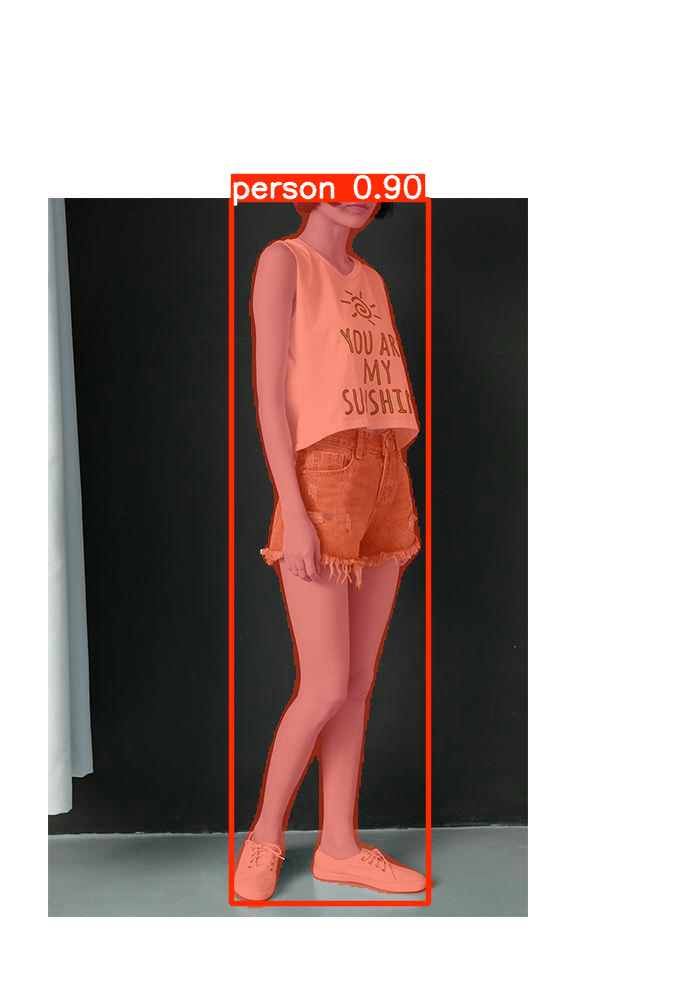

Fine-tuned on DeepFashion2 subset:


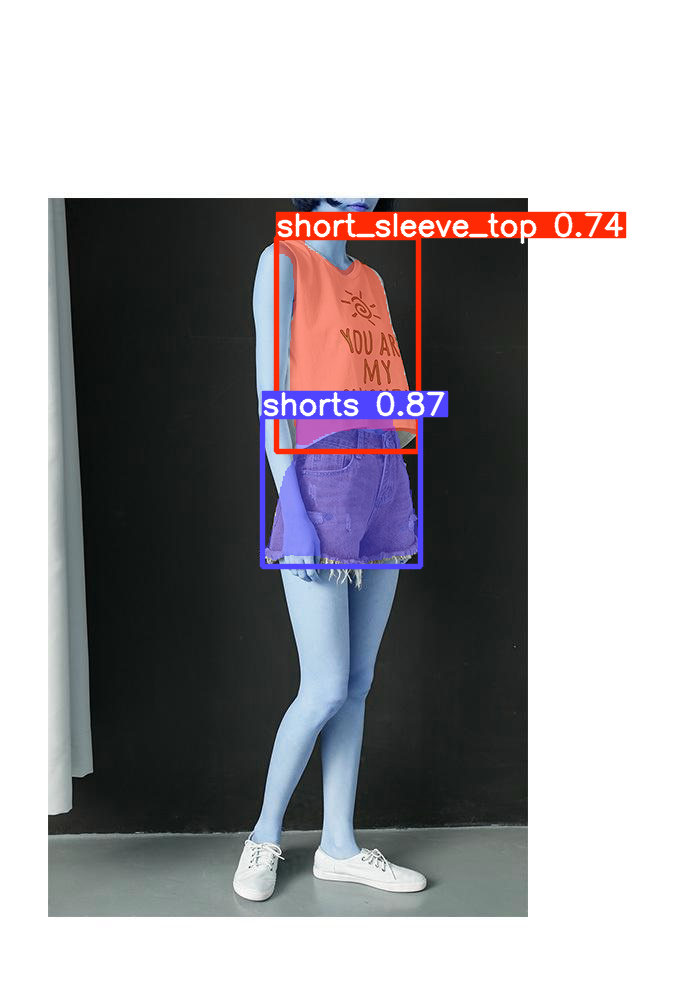

In [23]:
from PIL import Image
from IPython.display import display

test_img = "/content/data/df2_subset_5000/images/133298.jpg"
# baseline
base_model = YOLO("yolov8s-seg.pt")
base_res = base_model(test_img, task="segment")
# finetuned
ft_model = best_model_from_txt
ft_res = ft_model(test_img, task="segment")

base_img = Image.fromarray(base_res[0].plot())
ft_img = Image.fromarray(ft_res[0].plot())

print("Baseline (COCO-pretrained):")
display(base_img)
print("Fine-tuned on DeepFashion2 subset:")
display(ft_img)

### 2.5 *TRAINING* Fine Tune on 5000 Dataset

In [ ]:
from ultralytics import YOLO
import itertools
import os, shutil
import pandas as pd
from pathlib import Path

# Paths
DATA_YAML = "/content/data/df2_yolo_subset/df2_subset.yaml"
project_name = "/content/data/df2_yolo_exps"
WEIGHTS_ROOT = Path("/content/drive/MyDrive/DL4CVProject/yolo-5000-weights")

WEIGHTS_ROOT.mkdir(parents=True, exist_ok=True)

# Hyperparameters
freeze_list = [10]
epochs_list = [40]
batch_list  = [4]
lr0_list = [1e-3]

metric_col = "metrics/mAP50-95(M)"

best_run_info = None
summary_rows = []

for freeze, epochs, batch, lr0 in itertools.product(
    freeze_list, epochs_list, batch_list, lr0_list
):
    run_name = f"f{freeze}_e{epochs}_b{batch}_lr{lr0:g}"
    print(f"\n=== Starting experiment: {run_name} ===")

    model = YOLO("yolov8s-seg.pt")

    results = model.train(
        data=DATA_YAML,
        task="segment",
        epochs=epochs,
        imgsz=640,
        batch=batch,
        lr0=lr0,
        freeze=freeze,
        project=project_name,
        name=run_name,
    )

    # Directory where this run was saved by YOLO
    run_dir = Path(model.trainer.save_dir)
    csv_path = run_dir / "results.csv"

    df = pd.read_csv(csv_path)
    if metric_col not in df.columns:
        print(f"Skipping {run_name}: no column '{metric_col}' in results.csv")
        continue

    best_idx = df[metric_col].idxmax()
    best_row = df.loc[best_idx]
    best_map = best_row[metric_col]

    print(f"Best {metric_col} for {run_name}: {best_map:.4f}")

    # Copy weights to Drive folder
    src_best = run_dir / "weights" / "best.pt"
    src_last = run_dir / "weights" / "last.pt"

    # Save with unique filename
    dst_best = WEIGHTS_ROOT / f"{run_name}_best.pt"
    dst_last = WEIGHTS_ROOT / f"{run_name}_last.pt"

    if src_best.exists():
        shutil.copy2(src_best, dst_best)
    else:
        print(f"WARNING: best.pt not found for {run_name}")

    if src_last.exists():
        shutil.copy2(src_last, dst_last)

    # Collect info for summary CSV
    summary_rows.append({
        "run": run_name,
        "freeze": freeze,
        "epochs": epochs,
        "batch": batch,
        "lr0": lr0,
        "best_map50_95": best_map,
        "run_dir": str(run_dir),
        "csv_path": str(csv_path),
        "best_weights": str(dst_best),
    })

    # Track global best run
    if (best_run_info is None) or (best_map > best_run_info["best_map"]):
        best_run_info = {
            "run": run_name,
            "freeze": freeze,
            "epochs": epochs,
            "batch": batch,
            "lr0": lr0,
            "best_map": best_map,
            "run_dir": str(run_dir),
            "best_weights": str(dst_best),
        }

# Save summary + best path to Drive
summary_df = pd.DataFrame(summary_rows).sort_values("best_map50_95", ascending=False)

summary_csv_path = WEIGHTS_ROOT / "experiments_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)

best_txt_path = WEIGHTS_ROOT / "best_model_path.txt"
with open(best_txt_path, "w") as f:
    f.write(best_run_info["best_weights"] + "\n")

print("\n===== DONE =====")
print("Summary CSV saved to:", summary_csv_path)
print("Best model path saved to:", best_txt_path)
print("Best config:", best_run_info)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

=== Starting experiment: f10_e40_b4_lr0.001 ===
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/df2_yolo_subset/df2_subset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015

### 2.6 Load Best subset_5000 YOLO Model

In [24]:
from ultralytics import YOLO

best_txt_path = "/content/drive/MyDrive/DL4CVProject/yolo-5000-weights/best_model_path.txt"
with open(best_txt_path, "r") as f:
    best_model_path = f.read().strip()

print("Best YOLO weights found at:")
print(best_model_path)

# Load YOLO model
best_yolo_model_5000 = YOLO(best_model_path)


Best YOLO weights found at:
/content/drive/MyDrive/DL4CVProject/yolo-5000-weights/f10_e40_b4_lr0.001_best.pt


## 3 *takes a while* Generate masked garment crops + metadata (using subset_5000 fine-tuned model)

In [7]:
import os
from ultralytics import YOLO
import cv2
import json
import numpy as np
from tqdm import tqdm

# Shop-only DeepFashion2 subset
IMG_DIR = "/content/data/subset_5000_v2/images"
PROJECT_DIR = "/content/drive/MyDrive/DL4CVProject"

# Keep separate from mixed df2_subset_5000 crops
CROPS_DIR = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop")
os.makedirs(CROPS_DIR, exist_ok=True)

META_PATH = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop_meta.jsonl")

# Load best YOLO model
model = best_yolo_model_5000
print("Loaded fine-tuned model. Classes:", model.names)

# Run on up to N shop images
N = 5000
img_list = sorted(os.listdir(IMG_DIR))[:N]
print(f"Processing {len(img_list)} shop images with fine-tuned model...")

with open(META_PATH, "w") as meta_f:
    for img_name in tqdm(img_list):
        img_path = os.path.join(IMG_DIR, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print("Failed to read:", img_path)
            continue

        h, w = img.shape[:2]

        # run segmentation
        results = model(img, task="segment", verbose=False)
        r = results[0]

        if r.masks is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        classes = r.boxes.cls.cpu().numpy().astype(int)  # YOLO class indices 0..12
        masks = r.masks.data.cpu().numpy()
        names = model.names

        for i, (box, cls, mask) in enumerate(zip(boxes, classes, masks)):
            # resize mask to image size
            mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

            x1, y1, x2, y2 = box
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            if x2 <= x1 or y2 <= y1:
                continue

            crop = img[y1:y2, x1:x2]
            mask_crop = mask_resized[y1:y2, x1:x2]

            crop_masked = crop.copy()
            crop_masked[mask_crop < 0.5] = 0

            cls_name = names.get(cls, str(cls))
            base = os.path.splitext(img_name)[0]
            out_name = f"{base}_obj{i}_{cls_name}.png"
            out_path = os.path.join(CROPS_DIR, out_name)

            cv2.imwrite(out_path, crop_masked)

            meta = {
                "orig_image": img_name,
                "crop_file": out_name,
                "bbox": [int(x1), int(y1), int(x2), int(y2)],
                "class_id": int(cls),
                "class_name": cls_name,
                "source": "shop_v2",
            }
            meta_f.write(json.dumps(meta) + "\n")

print("Done. Shop-only fine-tuned crops saved to:", CROPS_DIR)
print("Shop-only metadata saved to:", META_PATH)


Loaded fine-tuned model. Classes: {0: 'short_sleeve_top', 1: 'long_sleeve_top', 2: 'short_sleeve_outwear', 3: 'long_sleeve_outwear', 4: 'vest', 5: 'sling', 6: 'shorts', 7: 'trousers', 8: 'skirt', 9: 'short_sleeve_dress', 10: 'long_sleeve_dress', 11: 'vest_dress', 12: 'sling_dress'}
Processing 5000 shop images with fine-tuned model...


100%|██████████| 5000/5000 [53:26<00:00,  1.56it/s]

Done. Shop-only fine-tuned crops saved to: /content/drive/MyDrive/DL4CVProject/garment_crops_finetuned_shop
Shop-only metadata saved to: /content/drive/MyDrive/DL4CVProject/garment_crops_finetuned_shop_meta.jsonl


Sanity Check

Showing these shop-only crops: ['000034_obj0_short_sleeve_top.png', '000034_obj0_shorts.png', '000034_obj1_shorts.png', '000034_obj1_vest.png', '000076_obj0_short_sleeve_top.png', '000076_obj0_trousers.png']


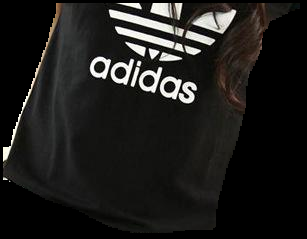

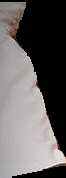

In [9]:
from IPython.display import display
from PIL import Image

crop_files = sorted(os.listdir(CROPS_DIR))[:6]
print("Showing these shop-only crops:", crop_files)

for cf in crop_files:
    cp = os.path.join(CROPS_DIR, cf)
    display(Image.open(cp))


## 4 ResNet Compatibility Model

### 4.1 Helper Functions

DeepFashion2 to Coarse Type

In [25]:
COARSE_TYPES = ["top", "bottom", "outerwear", "dress"]
TYPE2ID = {t: i for i, t in enumerate(COARSE_TYPES)}

# DeepFashion2 → coarse type
DF2_TO_COARSE = {
    1: "top",      # short_sleeve_top
    2: "top",      # long_sleeve_top
    3: "outerwear",# short_sleeve_outwear
    4: "outerwear",# long_sleeve_outwear
    5: "top",      # vest
    6: "top",      # sling
    7: "bottom",   # shorts
    8: "bottom",   # trousers
    9: "bottom",   # skirt
    10: "dress",   # short_sleeve_dress
    11: "dress",   # long_sleeve_dress
    12: "dress",   # vest_dress
    13: "dress",   # sling_dress
}

# Takes in DeepFashion2 category and returns corresponding coarse type
def df2_class_to_type_id(class_id: int) -> int:
    coarse = DF2_TO_COARSE.get(class_id, None)
    if coarse is None:
        return -1
    return TYPE2ID[coarse]


Transforms

In [26]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import random
import json
from itertools import combinations

# Preprocessing Polyvore product images before they go into your ResNet encoder so that model more robust to shifts, color changes, zooming, etc.
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# removes all randomness → ensures stable compatibility scores
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


### 4.2 ResNet18 Model

In [27]:
from torchvision import models
import torch
from torch import nn
import torch.nn.functional as F

class CompatibilityModel(nn.Module):
    def __init__(self, embedding_dim=256, type_dim=32, hidden_dim=256,
                 num_types=len(COARSE_TYPES)):
        super().__init__()

        # ImageNet-pretrained ResNet18
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_feats = base.fc.in_features
        base.fc = nn.Identity()
        self.cnn = base

        self.fc_embed = nn.Linear(num_feats, embedding_dim)
        self.type_emb = nn.Embedding(num_types, type_dim)

        pair_input_dim = 2 * (embedding_dim + type_dim)
        self.pair_mlp = nn.Sequential(
            nn.Linear(pair_input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1),
        )

    def encode_item(self, img: torch.Tensor, type_ids: torch.Tensor):
        """
        img: [B, 3, H, W]
        type_ids: [B]
        returns: [B, embedding_dim + type_dim]
        """
        feats = self.cnn(img)
        emb = self.fc_embed(feats)
        emb = F.normalize(emb, p=2, dim=-1)
        t_emb = self.type_emb(type_ids)
        return torch.cat([emb, t_emb], dim=-1)

    def forward(self, img_a, type_a, img_b, type_b):
        """
        Returns logits for pairwise compatibility (before sigmoid).
        """
        h_a = self.encode_item(img_a, type_a)
        h_b = self.encode_item(img_b, type_b)
        pair_feat = torch.cat([h_a, h_b], dim=-1)
        logits = self.pair_mlp(pair_feat).squeeze(-1)
        return logits


### 4.3 *DONT RUN* Abandoned Polyvore Dataset based training Pipeline

Create Polyvore Pair Dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from itertools import combinations
from pathlib import Path
import torch
import json
import os
import random

class PolyvorePairDataset(Dataset):
    def __init__(
        self,
        items_json_path: str,
        outfits_json_path: str,
        subset_root: str,
        transform,
        n_negatives_per_pos: int = 1,
        valid_pair_types=None,
    ):
        """
        items_json_path:  path to items_subset.json
        outfits_json_path: path to outfits_train_subset.json (or val)
        subset_root:      folder containing images/, items_subset.json, ...
        """
        self.subset_root = Path(subset_root)
        self.transform = transform
        self.n_neg = n_negatives_per_pos

        #Load items and outfits
        with open(items_json_path, "r", encoding="utf-8") as f:
            self.items_meta = json.load(f)

        with open(outfits_json_path, "r", encoding="utf-8") as f:
            self.outfits = json.load(f)

        self.item_typeid = {}
        self.item_imgpath = {}

        for item_id, meta in self.items_meta.items():
            coarse = meta.get("coarse_type")
            if coarse not in TYPE2ID:
                continue
            type_id = TYPE2ID[coarse]

            rel = meta.get("image_relpath")
            if rel is None:
                continue

            rel = rel.replace("\\", "/")
            img_abspath = self.subset_root / rel

            if not img_abspath.is_file():
                continue

            self.item_typeid[item_id] = type_id
            self.item_imgpath[item_id] = str(img_abspath)

        print(f"Usable items in subset: {len(self.item_typeid):,}")

        if valid_pair_types is None:
            valid_pair_types = {
                ("top", "bottom"),
                ("top", "outerwear"),
                ("bottom", "outerwear"),
                ("dress", "outerwear"),
            }
        self.valid_pair_type_ids = {
            (TYPE2ID[a], TYPE2ID[b]) for a, b in valid_pair_types
        } | {
            (TYPE2ID[b], TYPE2ID[a]) for a, b in valid_pair_types
        }

        self.pos_pairs = []
        self.item_ids_by_type = {tid: [] for tid in range(len(COARSE_TYPES))}
        for item_id, tid in self.item_typeid.items():
            self.item_ids_by_type[tid].append(item_id)

        usable_outfits = 0
        for outfit in self.outfits:
            ids_in_outfit = [iid for iid in outfit["item_ids"] if iid in self.item_typeid]
            if len(ids_in_outfit) < 2:
                continue
            usable_outfits += 1
            for a, b in combinations(ids_in_outfit, 2):
                ta = self.item_typeid[a]
                tb = self.item_typeid[b]
                if (ta, tb) in self.valid_pair_type_ids:
                    self.pos_pairs.append((a, b))

        print(f"Usable outfits: {usable_outfits:,}")
        print(f"Positive pairs: {len(self.pos_pairs):,}")

        if len(self.pos_pairs) == 0:
            raise RuntimeError("No positive pairs found – check valid_pair_types or data!")

        self.num_pos = len(self.pos_pairs)
        self.length = self.num_pos * (1 + self.n_neg)

    def __len__(self):
        return self.length

    def _load_item(self, item_id: str):
        img = Image.open(self.item_imgpath[item_id]).convert("RGB")
        img = self.transform(img)
        type_id = self.item_typeid[item_id]
        return img, type_id

    def __getitem__(self, idx):
        pair_idx = idx // (1 + self.n_neg)
        is_neg = (idx % (1 + self.n_neg) != 0)

        item_a, item_b_pos = self.pos_pairs[pair_idx]

        if not is_neg:
            img_a, type_a = self._load_item(item_a)
            img_b, type_b = self._load_item(item_b_pos)
            label = 1.0
        else:
            img_a, type_a = self._load_item(item_a)
            type_b_target = self.item_typeid[item_b_pos]
            neg_candidates = self.item_ids_by_type[type_b_target]

            while True:
                neg_id = random.choice(neg_candidates)
                if neg_id != item_b_pos:
                    break

            img_b, type_b = self._load_item(neg_id)
            label = 0.0

        return img_a, type_a, img_b, type_b, torch.tensor(label, dtype=torch.float32)


Training Loop

In [ ]:
import itertools
import os
import pandas as pd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Hyperparameter grids
freeze_list = [0]
epochs_list = [20]
batch_list = [4, 8]
lr0_list = [1e-3, 5e-4]

project_root = os.path.join(SUBSET_ROOT, "compat_exps")
os.makedirs(project_root, exist_ok=True)

best_run_info = None
best_val_acc = -1.0

for freeze, num_epochs, batch_size, lr0 in itertools.product(
    freeze_list, epochs_list, batch_list, lr0_list
):
    run_name = f"f{freeze}_e{num_epochs}_b{batch_size}_lr{lr0:g}"
    run_dir = os.path.join(project_root, run_name)
    os.makedirs(run_dir, exist_ok=True)

    print(f"\n=== Starting experiment: {run_name} ===")

    # DataLoaders for this run (batch size varies)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    model = CompatibilityModel().to(device)

    if freeze > 0:
        for p in model.cnn.parameters():
            p.requires_grad = False
        print("  -> Freezing CNN backbone parameters")

    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr0,
    )
    criterion = nn.BCEWithLogitsLoss()

    history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for img_a, type_a, img_b, type_b, labels in tqdm(
            train_loader,
            desc=f"{run_name} | epoch {epoch+1}/{num_epochs}",
            leave=False,
        ):
            img_a = img_a.to(device)
            img_b = img_b.to(device)
            type_a = type_a.to(device, dtype=torch.long)
            type_b = type_b.to(device, dtype=torch.long)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(img_a, type_a, img_b, type_b)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img_a.size(0)

        epoch_loss = running_loss / len(train_dataset)
        history.append(epoch_loss)
        print(f"  Epoch {epoch+1}/{num_epochs} - train loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img_a, type_a, img_b, type_b, labels in val_loader:
            img_a = img_a.to(device)
            img_b = img_b.to(device)
            type_a = type_a.to(device, dtype=torch.long)
            type_b = type_b.to(device, dtype=torch.long)
            labels = labels.to(device)

            logits = model(img_a, type_a, img_b, type_b)
            loss = criterion(logits, labels)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            total += labels.numel()
            correct += (preds == labels).sum().item()
            val_loss += loss.item() * labels.size(0)

    val_loss /= total
    val_acc = correct / total
    print(f"  -> Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

    ckpt_path = os.path.join(run_dir, "compat_model_polyvore.pth")
    torch.save(model.state_dict(), ckpt_path)

    results_row = {
        "run": run_name,
        "freeze": freeze,
        "epochs": num_epochs,
        "batch": batch_size,
        "lr0": lr0,
        "final_train_loss": history[-1],
        "val_loss": val_loss,
        "val_acc": val_acc,
        "ckpt_path": ckpt_path,
    }
    pd.DataFrame([results_row]).to_csv(
        os.path.join(run_dir, "results.csv"), index=False
    )

    # Track best run by val accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_run_info = results_row

print("\n===== DONE =====")
print("Best run:", best_run_info)
print("Best model path:", best_run_info["ckpt_path"] if best_run_info else "N/A")


=== Starting experiment: f0_e20_b4_lr0.001 ===


f0_e20_b4_lr0.001 | epoch 1/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 1/20 - train loss: 0.6950


f0_e20_b4_lr0.001 | epoch 2/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 2/20 - train loss: 0.6936


f0_e20_b4_lr0.001 | epoch 3/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
          ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^

  Epoch 3/20 - train loss: 0.6938


f0_e20_b4_lr0.001 | epoch 4/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
 ^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
 ^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process'  
    ^ ^ ^  ^  ^ ^ ^^^^^^^^^^^
  File 

  Epoch 4/20 - train loss: 0.6935


f0_e20_b4_lr0.001 | epoch 5/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 5/20 - train loss: 0.6933


f0_e20_b4_lr0.001 | epoch 6/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

  Epoch 6/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 7/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^
if w.is_alive():A

  Epoch 7/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 8/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 8/20 - train loss: 0.6933


f0_e20_b4_lr0.001 | epoch 9/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 9/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 10/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 10/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 11/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 11/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 12/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 12/20 - train loss: 0.6933


f0_e20_b4_lr0.001 | epoch 13/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 13/20 - train loss: 0.6933


f0_e20_b4_lr0.001 | epoch 14/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

  Epoch 14/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 15/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>

  Epoch 15/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 16/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers() 
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive(): 
  ^^  ^^ ^^ ^  ^^^^^^^^^^^^^^^^^^

  Epoch 16/20 - train loss: 0.6933


f0_e20_b4_lr0.001 | epoch 17/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^
^ ^
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
^^ ^^^^^ ^^^  ^^ 
    File "/usr/lib

  Epoch 17/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 18/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^^

    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
       ^^ ^ ^ ^ ^ ^   ^^^^^^^^^^^^^^^^^^

  Epoch 18/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 19/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200> 
Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^
^ ^  ^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^^^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^^  ^  ^ 
     File "/usr/l

  Epoch 19/20 - train loss: 0.6932


f0_e20_b4_lr0.001 | epoch 20/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 20/20 - train loss: 0.6932
  -> Val loss: 0.6932, Val acc: 0.5000

=== Starting experiment: f0_e20_b4_lr0.0005 ===


f0_e20_b4_lr0.0005 | epoch 1/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 1/20 - train loss: 0.6947


f0_e20_b4_lr0.0005 | epoch 2/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 2/20 - train loss: 0.6937


f0_e20_b4_lr0.0005 | epoch 3/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 3/20 - train loss: 0.6940


f0_e20_b4_lr0.0005 | epoch 4/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200> 
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():
^ ^ ^ ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' ^
^ ^ ^  ^ ^ ^ ^ ^ ^ ^ ^^
^^  File "/

  Epoch 4/20 - train loss: 0.6937


f0_e20_b4_lr0.0005 | epoch 5/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

            ^  ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

  Epoch 5/20 - train loss: 0.6937


f0_e20_b4_lr0.0005 | epoch 6/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>  
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    ^if w.is_alive():
 ^^^  ^^ ^ ^ ^ ^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^  ^^  ^ 
   File "/usr/lib

  Epoch 6/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 7/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive():
                ^^^^^^^^^^^^^^^^^^^^^^^^^

  Epoch 7/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 8/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 8/20 - train loss: 0.6932


f0_e20_b4_lr0.0005 | epoch 9/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 9/20 - train loss: 0.6932


f0_e20_b4_lr0.0005 | epoch 10/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 10/20 - train loss: 0.6934


f0_e20_b4_lr0.0005 | epoch 11/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 11/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 12/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 12/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 13/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 13/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 14/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 14/20 - train loss: 0.6932


f0_e20_b4_lr0.0005 | epoch 15/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 15/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 16/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^Exception ignored in: ^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
      self._shutdown_workers()   
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():  
^ ^ ^ ^ ^ ^^  ^^^^^^^^^^^^^^^^^^

  Epoch 16/20 - train loss: 0.6930


f0_e20_b4_lr0.0005 | epoch 17/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception ignored in: AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>self._shutdown_workers()

  Epoch 17/20 - train loss: 0.6932


f0_e20_b4_lr0.0005 | epoch 18/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive():   
^^   ^^^ ^ ^ ^ ^^^^^^^^^^^^^^^^^

  Epoch 18/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 19/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
 ^ ^  ^  ^^ ^^^^^^^^^^

  Epoch 19/20 - train loss: 0.6933


f0_e20_b4_lr0.0005 | epoch 20/20:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 20/20 - train loss: 0.6924
  -> Val loss: 0.6871, Val acc: 0.5658

=== Starting experiment: f0_e20_b8_lr0.001 ===


f0_e20_b8_lr0.001 | epoch 1/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 1/20 - train loss: 0.6940


f0_e20_b8_lr0.001 | epoch 2/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 2/20 - train loss: 0.6933


f0_e20_b8_lr0.001 | epoch 3/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 3/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 4/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 4/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 5/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()

AssertionError  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
:     c

  Epoch 5/20 - train loss: 0.6936


f0_e20_b8_lr0.001 | epoch 6/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 6/20 - train loss: 0.6933


f0_e20_b8_lr0.001 | epoch 7/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 7/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 8/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 8/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 9/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 9/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 10/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 10/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 11/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 11/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 12/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 12/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 13/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 13/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 14/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 14/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 15/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 15/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 16/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 16/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 17/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^^
^ ^ ^ ^ ^ ^^ ^ ^^^^

  Epoch 17/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 18/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 18/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 19/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

     if w.is_alive(): 
           ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^

  File "/usr/lib/python

  Epoch 19/20 - train loss: 0.6932


f0_e20_b8_lr0.001 | epoch 20/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():
    self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
    ^ ^^^ ^^ ^ ^ ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^ ^  ^^
    File "/usr/lib/

  Epoch 20/20 - train loss: 0.6932
  -> Val loss: 0.6932, Val acc: 0.5000

=== Starting experiment: f0_e20_b8_lr0.0005 ===


f0_e20_b8_lr0.0005 | epoch 1/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 1/20 - train loss: 0.6949


f0_e20_b8_lr0.0005 | epoch 2/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 2/20 - train loss: 0.6936


f0_e20_b8_lr0.0005 | epoch 3/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 3/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 4/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 4/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 5/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 5/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 6/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 6/20 - train loss: 0.6932


f0_e20_b8_lr0.0005 | epoch 7/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 7/20 - train loss: 0.6936


f0_e20_b8_lr0.0005 | epoch 8/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200><function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
    if w.is_alive():
           ^^ ^^^ ^ ^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^   ^ ^ ^ 
  File "/usr/lib

  Epoch 8/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 9/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    
self._shutdown_workers()  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive(): 
             ^^^^ ^^^ ^ ^ ^^^^^^^^
^  File

  Epoch 9/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 10/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 10/20 - train loss: 0.6932


f0_e20_b8_lr0.0005 | epoch 11/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 11/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 12/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 12/20 - train loss: 0.6932


f0_e20_b8_lr0.0005 | epoch 13/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 13/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 14/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 14/20 - train loss: 0.6933


f0_e20_b8_lr0.0005 | epoch 15/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 15/20 - train loss: 0.6932


f0_e20_b8_lr0.0005 | epoch 16/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 16/20 - train loss: 0.6930


f0_e20_b8_lr0.0005 | epoch 17/20:   0%|          | 0/1820 [00:00<?, ?it/s]

  Epoch 17/20 - train loss: 0.6931


f0_e20_b8_lr0.0005 | epoch 18/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 18/20 - train loss: 0.6925


f0_e20_b8_lr0.0005 | epoch 19/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 19/20 - train loss: 0.6931


f0_e20_b8_lr0.0005 | epoch 20/20:   0%|          | 0/1820 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 20/20 - train loss: 0.6926
  -> Val loss: 0.6910, Val acc: 0.5441

=== Starting experiment: f0_e40_b4_lr0.001 ===


f0_e40_b4_lr0.001 | epoch 1/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 1/40 - train loss: 0.6944


f0_e40_b4_lr0.001 | epoch 2/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 2/40 - train loss: 0.6936


f0_e40_b4_lr0.001 | epoch 3/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 3/40 - train loss: 0.6934


f0_e40_b4_lr0.001 | epoch 4/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 4/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 5/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 5/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 6/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>    
self._shutdown_workers(

  Epoch 6/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 7/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): ^
 ^ ^^ ^ ^ ^  ^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^^ ^ ^ ^ 
    File "/usr/lib/

  Epoch 7/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 8/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200> 
   Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^^self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^^^if w.is_alive():
^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
       ^ ^ ^^  ^^ ^^ ^^^^^^^^^
^  File

  Epoch 8/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 9/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

  Epoch 9/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 10/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 10/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 11/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 11/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 12/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 12/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 13/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 13/40 - train loss: 0.6931


f0_e40_b4_lr0.001 | epoch 14/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 14/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 15/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 15/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 16/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

^Traceback (most recent call last):

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive(): 
                 ^^^^^^^^^^^^^^^^^^^^^^
  

  Epoch 16/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 17/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200><function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in 

  Epoch 17/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 18/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200> 
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^
^ ^ ^  ^^^  ^^ ^^^^^^^^

  Epoch 18/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 19/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^^Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
AssertionError    : can only test a child process
self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

  Epoch 19/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 20/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 20/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 21/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 21/40 - train loss: 0.6931


f0_e40_b4_lr0.001 | epoch 22/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 22/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 23/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 23/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 24/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 24/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 25/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 25/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 26/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 26/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 27/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 27/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 28/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200><function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
            ^^^ ^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^ ^  ^ 
  File "/usr/lib/

  Epoch 28/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 29/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()^
^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    ^if w.is_alive():^
 ^ ^ ^ ^ ^ ^ ^^^^^^

  Epoch 29/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 30/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200><function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
     if w.is_alive(): 
        ^ ^^^^ ^ ^ ^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^ ^
   File "/usr/lib/pyt

  Epoch 30/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 31/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>^^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^    self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():
^^ ^

  Epoch 31/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 32/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python

  Epoch 32/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 33/40:   0%|          | 0/3640 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de5ebbbe200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 33/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 34/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 34/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 35/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 35/40 - train loss: 0.6933


f0_e40_b4_lr0.001 | epoch 36/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 36/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 37/40:   0%|          | 0/3640 [00:00<?, ?it/s]

  Epoch 37/40 - train loss: 0.6932


f0_e40_b4_lr0.001 | epoch 38/40:   0%|          | 0/3640 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader

SUBSET_ROOT = "/content/data/polyvore_subset_5000"

items_json_path = os.path.join(SUBSET_ROOT, "items_subset.json")
train_outfits_json = os.path.join(SUBSET_ROOT, "outfits_train_subset.json")
val_outfits_json = os.path.join(SUBSET_ROOT, "outfits_val_subset.json")

print("Items:", items_json_path)
print("Train outfits:", train_outfits_json)
print("Val outfits:", val_outfits_json)

train_dataset = PolyvorePairDataset(
    items_json_path=items_json_path,
    outfits_json_path=train_outfits_json,
    subset_root=SUBSET_ROOT,
    transform=train_transform,
    n_negatives_per_pos=1,
)

val_dataset = PolyvorePairDataset(
    items_json_path=items_json_path,
    outfits_json_path=val_outfits_json,
    subset_root=SUBSET_ROOT,
    transform=eval_transform,
    n_negatives_per_pos=1,
)

Items: /content/data/polyvore_subset_5000/items_subset.json
Train outfits: /content/data/polyvore_subset_5000/outfits_train_subset.json
Val outfits: /content/data/polyvore_subset_5000/outfits_val_subset.json
Usable items in subset: 12,013
Usable outfits: 4,500
Positive pairs: 7,280
Usable items in subset: 12,013
Usable outfits: 500
Positive pairs: 760


Saving Temporary Results into Drive folder

In [ ]:
import os, shutil
from pathlib import Path
import pandas as pd

# Where your compat experiments live
SUBSET_ROOT = "/content/data/polyvore_subset_5000"
PROJECT_ROOT = Path(SUBSET_ROOT) / "compat_exps"

# Where you want to persist everything in Drive
DEST_ROOT = Path("/content/drive/MyDrive/DL4CVProject/resnet18-experiments-weights")
DEST_ROOT.mkdir(parents=True, exist_ok=True)

summary_rows = []

for run_dir in PROJECT_ROOT.iterdir():
    if not run_dir.is_dir():
        continue

    run_name = run_dir.name
    results_path = run_dir / "results.csv"
    weights_path = run_dir / "compat_model_polyvore.pth"

    # Skip runs that didn't finish / don't have results
    if not results_path.exists():
        print(f"Skipping {run_name}: no results.csv")
        continue

    # 1) copy results.csv (rename so they don't overwrite each other)
    dst_results = DEST_ROOT / f"{run_name}_results.csv"
    shutil.copy2(results_path, dst_results)

    # 2) copy weights
    if weights_path.exists():
        dst_weights = DEST_ROOT / f"{run_name}_compat_model_polyvore.pth"
        shutil.copy2(weights_path, dst_weights)
    else:
        print(f"WARNING: {run_name} has results.csv but no compat_model_polyvore.pth")
        dst_weights = None

    # 3) load the single-row CSV into the summary
    df = pd.read_csv(results_path)
    if "run" not in df.columns:
        df["run"] = run_name
    df["ckpt_path_drive"] = str(dst_weights) if dst_weights is not None else ""
    summary_rows.append(df)

# Build global summary
if summary_rows:
    summary_df = pd.concat(summary_rows, ignore_index=True)
    summary_path = DEST_ROOT / "experiments_summary.csv"
    summary_df.to_csv(summary_path, index=False)
    print("Saved experiment summary to:", summary_path)

    # Pick best by val_acc
    if "val_acc" in summary_df.columns:
        best_idx = summary_df["val_acc"].idxmax()
        best_row = summary_df.loc[best_idx]
        best_weights_drive = best_row["ckpt_path_drive"]

        # Save text file listing best model path
        best_txt = DEST_ROOT / "best_model_path.txt"
        with open(best_txt, "w") as f:
            f.write(str(best_weights_drive) + "\n")

        print("Best run:", best_row["run"])
        print("Best model weights in Drive:", best_weights_drive)
        print("Best model path file:", best_txt)
    else:
        print("Summary has no 'val_acc' column – not picking a best run.")
else:
    print("No finished runs found in compat_exps.")


Skipping f0_e40_b4_lr0.0005: no results.csv
Saved experiment summary to: /content/drive/MyDrive/DL4CVProject/resnet18-experiments-weights/experiments_summary.csv
Best run: f0_e20_b4_lr0.0005
Best model weights in Drive: /content/drive/MyDrive/DL4CVProject/resnet18-experiments-weights/f0_e20_b4_lr0.0005_compat_model_polyvore.pth
Best model path file: /content/drive/MyDrive/DL4CVProject/resnet18-experiments-weights/best_model_path.txt


Display the Experiment Results

In [ ]:
import pandas as pd
import os
import glob

RESNET_ROOT = "/content/drive/MyDrive/DL4CVProject/resnet18-experiments-weights"

rows = []

# read every file ending with _results.csv
pattern = os.path.join(RESNET_ROOT, "*_results.csv")

for csv_path in glob.glob(pattern):
    df = pd.read_csv(csv_path)
    row = df.iloc[0]  # each results.csv has only one row

    run_name = row.get("run", os.path.basename(csv_path).replace("_results.csv",""))
    val_acc = row.get("val_acc", None)
    val_loss = row.get("val_loss", None)
    train_loss = row.get("final_train_loss", None)

    rows.append({
        "run": run_name,
        "val_acc": val_acc,
        "val_loss": val_loss,
        "train_loss": train_loss
    })

# build dataframe sorted by val accuracy
summary_df = pd.DataFrame(rows).sort_values("val_acc", ascending=False)

# pretty display
print("\n=== Ranked Experiments by Validation Accuracy ===\n")
print(summary_df.to_string(index=False))

# show the best run separately
best = summary_df.iloc[0]
print("\n=== Best Run ===")
print(best)


=== Ranked Experiments by Validation Accuracy ===

               run  val_acc  val_loss  train_loss
f0_e20_b4_lr0.0005 0.565789  0.687083    0.692371
f0_e20_b8_lr0.0005 0.544079  0.690983    0.692576
 f0_e40_b4_lr0.001 0.500000  0.693166    0.693262
 f0_e20_b4_lr0.001 0.500000  0.693152    0.693242
 f0_e20_b8_lr0.001 0.500000  0.693187    0.693212
  f0_e2_b4_lr0.001 0.481579  0.695871    0.693403

=== Best Run ===
run           f0_e20_b4_lr0.0005
val_acc                 0.565789
val_loss                0.687083
train_loss              0.692371
Name: 5, dtype: object


Load Best Model from Drive

In [ ]:
import pandas as pd
from pathlib import Path

RES18_ROOT = Path("/content/drive/MyDrive/DL4CVProject/resnet18-experiments-weights")

# Load experiment summary
summary_path = RES18_ROOT / "experiments_summary.csv"
summary_df = pd.read_csv(summary_path)

# Sort by validation accuracy
summary_df = summary_df.sort_values("val_acc", ascending=False)

best_run = summary_df.iloc[0]

best_weights_path = best_run["ckpt_path_drive"]
print("Loading weights from:", best_weights_path)

# Create model + load weights
best_res18_model = CompatibilityModel().to(device)
best_res18_model.load_state_dict(torch.load(best_weights_path, map_location=device))

best_res18_model.eval()
print("✔ Best ResNet18 model loaded and ready!")

Loading weights from: /content/drive/MyDrive/DL4CVProject/resnet18-experiments-weights/f0_e20_b4_lr0.0005_compat_model_polyvore.pth
✔ Best ResNet18 model loaded and ready!


### Testing ResNet50 Model (don't use, worse than ResNet18)

In [ ]:
import os, torch
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchvision import models
from torch import nn
import torch.nn.functional as F

# Hyperparameters from best ResNet18
freeze = 0
num_epochs = 20
batch_size = 4
lr0 = 5e-4
patience = 4

# ResNet50
class CompatibilityModelResNet50(nn.Module):
    def __init__(self, embedding_dim=256, type_dim=32, hidden_dim=256,
                 num_types=len(COARSE_TYPES)):
        super().__init__()

        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_feats = base.fc.in_features
        base.fc = nn.Identity()
        self.cnn = base

        self.fc_embed = nn.Linear(num_feats, embedding_dim)
        self.type_emb = nn.Embedding(num_types, type_dim)

        pair_input_dim = 2 * (embedding_dim + type_dim)
        self.pair_mlp = nn.Sequential(
            nn.Linear(pair_input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1),
        )

    def encode_item(self, img: torch.Tensor, type_ids: torch.Tensor):
        feats = self.cnn(img)
        emb = self.fc_embed(feats)
        emb = F.normalize(emb, p=2, dim=-1)
        t_emb = self.type_emb(type_ids)
        return torch.cat([emb, t_emb], dim=-1)

    def forward(self, img_a, type_a, img_b, type_b):
        h_a = self.encode_item(img_a, type_a)
        h_b = self.encode_item(img_b, type_b)
        pair_feat = torch.cat([h_a, h_b], dim=-1)
        logits = self.pair_mlp(pair_feat).squeeze(-1)
        return logits


# Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

# Model, optimizer, loss
model50 = CompatibilityModelResNet50().to(device)

if freeze > 0:
    for p in model50.cnn.parameters():
        p.requires_grad = False
    print("  -> Freezing ResNet50 backbone parameters")

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model50.parameters()),
    lr=lr0,
)
criterion = nn.BCEWithLogitsLoss()

run_name_50 = f"resnet50_f{freeze}_e{num_epochs}_b{batch_size}_lr{lr0:g}"
print(f"\n=== Starting ResNet50 experiment: {run_name_50} ===")

# Early stopping + best checkpoint tracking
best_val_loss = float("inf")
best_epoch = -1
best_state_dict = None
epochs_without_improve = 0

epoch_logs = []

for epoch in range(num_epochs):
    model50.train()
    running_loss = 0.0

    for img_a, type_a, img_b, type_b, labels in tqdm(
        train_loader,
        desc=f"{run_name_50} | epoch {epoch+1}/{num_epochs}",
        leave=False,
    ):
        img_a = img_a.to(device)
        img_b = img_b.to(device)
        type_a = type_a.to(device, dtype=torch.long)
        type_b = type_b.to(device, dtype=torch.long)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model50(img_a, type_a, img_b, type_b)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img_a.size(0)

    train_loss = running_loss / len(train_dataset)

    # Validation
    model50.eval()
    val_loss_sum = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img_a, type_a, img_b, type_b, labels in val_loader:
            img_a = img_a.to(device)
            img_b = img_b.to(device)
            type_a = type_a.to(device, dtype=torch.long)
            type_b = type_b.to(device, dtype=torch.long)
            labels = labels.to(device)

            logits = model50(img_a, type_a, img_b, type_b)
            loss = criterion(logits, labels)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            total += labels.numel()
            correct += (preds == labels).sum().item()
            val_loss_sum += loss.item() * labels.size(0)

    val_loss = val_loss_sum / total
    val_acc = correct / total

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"- train loss: {train_loss:.4f}, "
        f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}"
    )

    # log metrics each epoch
    epoch_logs.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_state_dict = model50.state_dict()
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        if epochs_without_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

if best_state_dict is None:
    best_state_dict = model50.state_dict()

# Save best weights to drive
DEST_ROOT_50 = Path("/content/drive/MyDrive/DL4CVProject/resnet50-experiments-weights")
DEST_ROOT_50.mkdir(parents=True, exist_ok=True)

ckpt_path_50 = DEST_ROOT_50 / f"{run_name_50}_best_epoch{best_epoch}_compat_model_polyvore.pth"
torch.save(best_state_dict, ckpt_path_50)

log_df = pd.DataFrame(epoch_logs)
log_csv_path = DEST_ROOT_50 / f"{run_name_50}_epoch_log.csv"
log_df.to_csv(log_csv_path, index=False)

best_row = log_df.loc[log_df["epoch"] == best_epoch].iloc[0]
summary_row = {
    "run": run_name_50,
    "best_epoch": int(best_epoch),
    "freeze": freeze,
    "epochs_planned": num_epochs,
    "batch": batch_size,
    "lr0": lr0,
    "best_train_loss": float(best_row["train_loss"]),
    "best_val_loss": float(best_row["val_loss"]),
    "best_val_acc": float(best_row["val_acc"]),
    "ckpt_path_drive": str(ckpt_path_50),
}
summary_df = pd.DataFrame([summary_row])
summary_csv_50 = DEST_ROOT_50 / f"{run_name_50}_summary.csv"
summary_df.to_csv(summary_csv_50, index=False)

print("\n=== ResNet50 training complete ===")
print("Best epoch:", best_epoch)
print("Best val loss:", best_val_loss)
print("Best weights saved to:", ckpt_path_50)
print("Per-epoch log:", log_csv_path)
print("Summary CSV:", summary_csv_50)


=== Starting ResNet50 experiment: resnet50_f0_e20_b4_lr0.0005 ===


resnet50_f0_e20_b4_lr0.0005 | epoch 1/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 1/20 - train loss: 0.6947, val loss: 0.6933, val acc: 0.5000


resnet50_f0_e20_b4_lr0.0005 | epoch 2/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 2/20 - train loss: 0.6939, val loss: 0.6933, val acc: 0.5007


resnet50_f0_e20_b4_lr0.0005 | epoch 3/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 3/20 - train loss: 0.6936, val loss: 0.6932, val acc: 0.5000


resnet50_f0_e20_b4_lr0.0005 | epoch 4/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 4/20 - train loss: 0.6935, val loss: 0.6935, val acc: 0.5059


resnet50_f0_e20_b4_lr0.0005 | epoch 5/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 5/20 - train loss: 0.6936, val loss: 0.6932, val acc: 0.5007


resnet50_f0_e20_b4_lr0.0005 | epoch 6/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 6/20 - train loss: 0.6934, val loss: 0.6931, val acc: 0.5059


resnet50_f0_e20_b4_lr0.0005 | epoch 7/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 7/20 - train loss: 0.6933, val loss: 0.6923, val acc: 0.4895


resnet50_f0_e20_b4_lr0.0005 | epoch 8/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 8/20 - train loss: 0.6931, val loss: 0.6932, val acc: 0.5007


resnet50_f0_e20_b4_lr0.0005 | epoch 9/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 9/20 - train loss: 0.6933, val loss: 0.6932, val acc: 0.5000


resnet50_f0_e20_b4_lr0.0005 | epoch 10/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 10/20 - train loss: 0.6933, val loss: 0.6932, val acc: 0.5039


resnet50_f0_e20_b4_lr0.0005 | epoch 11/20:   0%|          | 0/3640 [00:00<?, ?it/s]

Epoch 11/20 - train loss: 0.6933, val loss: 0.6931, val acc: 0.5000
Early stopping triggered at epoch 11

=== ResNet50 training complete ===
Best epoch: 7
Best val loss: 0.6922726386471798
Best weights saved to: /content/drive/MyDrive/DL4CVProject/resnet50-experiments-weights/resnet50_f0_e20_b4_lr0.0005_best_epoch7_compat_model_polyvore.pth
Per-epoch log: /content/drive/MyDrive/DL4CVProject/resnet50-experiments-weights/resnet50_f0_e20_b4_lr0.0005_epoch_log.csv
Summary CSV: /content/drive/MyDrive/DL4CVProject/resnet50-experiments-weights/resnet50_f0_e20_b4_lr0.0005_summary.csv


### 4.4 DF2 Shop-image based ResNet-18 Finetuning

#### 4.4.1 Define allowed type pairs and create splits

In [29]:
import json
import os
import random
from collections import defaultdict

PROJECT_DIR = "/content/drive/MyDrive/DL4CVProject"
CROPS_DIR = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop")
META_PATH = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop_meta.jsonl")

VALID_TYPE_PAIRS = {
    (TYPE2ID["top"], TYPE2ID["bottom"]),
    (TYPE2ID["top"], TYPE2ID["outerwear"]),
    (TYPE2ID["dress"], TYPE2ID["outerwear"]),
}

all_items = []  # list of dicts with index
by_image = defaultdict(list)

with open(META_PATH, "r") as f:
    for line in f:
        meta = json.loads(line)
        df2_class_id = int(meta["class_id"]) + 1
        type_id = df2_class_to_type_id(df2_class_id)
        if type_id < 0:
            continue  # skip unknown or unwanted categories

        meta["df2_class_id"] = df2_class_id
        meta["type_id"] = type_id

        idx = len(all_items)
        meta["idx"] = idx
        all_items.append(meta)
        by_image[meta["orig_image"]].append(idx)

print(f"Total valid shop crops: {len(all_items)}")
print(f"Unique shop images with crops: {len(by_image)}")

# train/val/test
SPLITS_PATH = os.path.join(PROJECT_DIR, "df2_shop_splits.json")

if os.path.exists(SPLITS_PATH):
    with open(SPLITS_PATH, "r") as f:
        img_to_split = json.load(f)
    print("Loaded existing splits from:", SPLITS_PATH)
else:
    images = list(by_image.keys())
    random.seed(42)
    random.shuffle(images)

    n = len(images)
    n_train = int(0.8 * n)
    n_val = int(0.1 * n)
    n_test = n - n_train - n_val

    train_imgs = set(images[:n_train])
    val_imgs   = set(images[n_train:n_train + n_val])
    test_imgs  = set(images[n_train + n_val:])

    img_to_split = {}
    for img in train_imgs:
        img_to_split[img] = "train"
    for img in val_imgs:
        img_to_split[img] = "val"
    for img in test_imgs:
        img_to_split[img] = "test"

    with open(SPLITS_PATH, "w") as f:
        json.dump(img_to_split, f, indent=2)
    print("Created and saved new splits to:", SPLITS_PATH)

# Quick sanity check
from collections import Counter
split_counts = Counter(img_to_split.values())
print("Image split counts:", split_counts)

Total valid shop crops: 10225
Unique shop images with crops: 4981
Loaded existing splits from: /content/drive/MyDrive/DL4CVProject/df2_shop_splits.json
Image split counts: Counter({'train': 3854, 'test': 483, 'val': 481})


#### 4.4.2 Build a Pair Dataset Class

In [30]:
import torch
from torch.utils.data import Dataset
from itertools import combinations
from PIL import Image

class DF2ShopPairDataset(Dataset):
    def __init__(
        self,
        crops_dir: str,
        meta_path: str,
        splits_path: str,
        split: str,
        transform,
        n_negatives_per_pos: int = 1,
        seed: int = 123,
    ):
        """
        crops_dir: folder with masked crops (shop-only)
        meta_path: garment_crops_finetuned_shop_meta.jsonl
        splits_path: df2_shop_splits.json
        split: "train", "val", or "test"
        transform: torchvision transform
        """
        assert split in {"train", "val", "test"}
        self.crops_dir = crops_dir
        self.transform = transform
        self.split = split
        self.n_negatives_per_pos = n_negatives_per_pos

        with open(splits_path, "r") as f:
            img_to_split = json.load(f)

        items = []
        by_image = defaultdict(list)
        with open(meta_path, "r") as f:
            for line in f:
                meta = json.loads(line)
                img_name = meta["orig_image"]
                if img_to_split.get(img_name, None) != split:
                    continue

                df2_class_id = int(meta["class_id"]) + 1  # YOLO idx -> DF2 id
                type_id = df2_class_to_type_id(df2_class_id)
                if type_id < 0:
                    continue

                meta["df2_class_id"] = df2_class_id
                meta["type_id"] = type_id

                idx = len(items)
                meta["idx"] = idx
                items.append(meta)
                by_image[img_name].append(idx)

        self.items = items
        self.by_image = by_image
        print(f"[{split}] crops: {len(self.items)}, images: {len(self.by_image)}")

        # type_id
        self.by_type = defaultdict(list)
        for meta in self.items:
            self.by_type[meta["type_id"]].append(meta["idx"])

        # positive pairs
        random.seed(seed)
        self.pairs = []
        for img_name, idxs in self.by_image.items():
            for i, j in combinations(idxs, 2):
                item_i = self.items[i]
                item_j = self.items[j]
                t_i = item_i["type_id"]
                t_j = item_j["type_id"]

                pair = (min(t_i, t_j), max(t_i, t_j))
                if pair not in VALID_TYPE_PAIRS:
                    continue

                # positive pair (occur in same image)
                self.pairs.append((i, j, 1))

                # generate negatives: keep first item, swap second
                for _ in range(self.n_negatives_per_pos):
                    # choose a random different image crop with same type as j (or i)
                    neg_idx = self._sample_negative_idx(
                        anchor_idx=i, target_type=t_j, anchor_image=img_name
                    )
                    if neg_idx is not None:
                        self.pairs.append((i, neg_idx, 0))

        print(f"[{split}] total pairs (pos + neg): {len(self.pairs)}")

    def _sample_negative_idx(self, anchor_idx: int, target_type: int, anchor_image: str):
        """Sample a negative crop with the given type, from a *different* image."""
        candidates = self.by_type.get(target_type, [])
        if not candidates:
            return None

        # try a few times to get a different image
        for _ in range(10):
            j = random.choice(candidates)
            if self.items[j]["orig_image"] != anchor_image:
                return j
        return None  # give up

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        idx_a, idx_b, label = self.pairs[idx]
        item_a = self.items[idx_a]
        item_b = self.items[idx_b]

        path_a = os.path.join(self.crops_dir, item_a["crop_file"])
        path_b = os.path.join(self.crops_dir, item_b["crop_file"])

        img_a = Image.open(path_a).convert("RGB")
        img_b = Image.open(path_b).convert("RGB")

        if self.transform is not None:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)

        type_a = item_a["type_id"]
        type_b = item_b["type_id"]

        return {
            "img_a": img_a,
            "img_b": img_b,
            "type_a": torch.tensor(type_a, dtype=torch.long),
            "type_b": torch.tensor(type_b, dtype=torch.long),
            "label": torch.tensor(label, dtype=torch.float32),
        }

#### 4.4.3 *TRAINING* Training Loop

In [35]:
from torch.utils.data import DataLoader

PROJECT_DIR = "/content/drive/MyDrive/DL4CVProject"
CROPS_DIR = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop")
META_PATH = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop_meta.jsonl")
SPLITS_PATH = os.path.join(PROJECT_DIR, "df2_shop_splits.json")

train_dataset = DF2ShopPairDataset(
    crops_dir=CROPS_DIR,
    meta_path=META_PATH,
    splits_path=SPLITS_PATH,
    split="train",
    transform=train_transform,
    n_negatives_per_pos=1,
)

val_dataset = DF2ShopPairDataset(
    crops_dir=CROPS_DIR,
    meta_path=META_PATH,
    splits_path=SPLITS_PATH,
    split="val",
    transform=eval_transform,
    n_negatives_per_pos=1,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

[train] crops: 7905, images: 3842
[train] total pairs (pos + neg): 6508
[val] crops: 978, images: 478
[val] total pairs (pos + neg): 830


In [ ]:
from pathlib import Path
import os
import torch

RES18_SHOP_ROOT = Path("/content/drive/MyDrive/DL4CVProject/resnet18-shop-weights")
RES18_SHOP_ROOT.mkdir(parents=True, exist_ok=True)

model = CompatibilityModel()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 10
best_val_acc = 0.0
best_ckpt_path = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        img_a = batch["img_a"].to(device)
        img_b = batch["img_b"].to(device)
        type_a = batch["type_a"].to(device)
        type_b = batch["type_b"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(img_a, type_a, img_b, type_b)  # shape [B]
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * img_a.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == labels).sum().item()
        total_samples += img_a.size(0)

    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    # validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            img_a = batch["img_a"].to(device)
            img_b = batch["img_b"].to(device)
            type_a = batch["type_a"].to(device)
            type_b = batch["type_b"].to(device)
            labels = batch["label"].to(device)

            logits = model(img_a, type_a, img_b, type_b)
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += img_a.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    # save epoch checkpoint
    ckpt_path = RES18_SHOP_ROOT / f"epoch{epoch+1:02d}_val{val_acc:.3f}.pt"
    torch.save(
        {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc,
            "train_loss": train_loss,
        },
        ckpt_path,
    )

    # update best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_ckpt_path = ckpt_path

        best_path = RES18_SHOP_ROOT / "best.pt"
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
                "train_loss": train_loss,
            },
            best_path,
        )

        # Write path
        with open(RES18_SHOP_ROOT / "best_model.txt", "w") as f:
            f.write(str(best_path))

        print(f"  ➜ New best model saved at: {best_path}")

print("Training complete.")
print("Best validation accuracy:", best_val_acc)
print("Best checkpoint:", best_ckpt_path)

Epoch 1: train_loss=0.6906, train_acc=0.522, val_acc=0.553
  ➜ New best model saved at: /content/drive/MyDrive/DL4CVProject/resnet18-shop-weights/best.pt
Epoch 2: train_loss=0.6854, train_acc=0.561, val_acc=0.572
  ➜ New best model saved at: /content/drive/MyDrive/DL4CVProject/resnet18-shop-weights/best.pt
Epoch 3: train_loss=0.6792, train_acc=0.576, val_acc=0.541
Epoch 4: train_loss=0.6732, train_acc=0.588, val_acc=0.568
Epoch 5: train_loss=0.6671, train_acc=0.596, val_acc=0.556
Epoch 6: train_loss=0.6634, train_acc=0.608, val_acc=0.561
Epoch 7: train_loss=0.6576, train_acc=0.619, val_acc=0.565
Epoch 8: train_loss=0.6480, train_acc=0.626, val_acc=0.587
  ➜ New best model saved at: /content/drive/MyDrive/DL4CVProject/resnet18-shop-weights/best.pt
Epoch 9: train_loss=0.6416, train_acc=0.637, val_acc=0.611
  ➜ New best model saved at: /content/drive/MyDrive/DL4CVProject/resnet18-shop-weights/best.pt
Epoch 10: train_loss=0.6305, train_acc=0.654, val_acc=0.593
Training complete.
Best valid

#### 4.4.4 Load Best Model from Drive

In [36]:
BEST_MODEL_PATH = Path("/content/drive/MyDrive/DL4CVProject/resnet18-shop-weights/best.pt")

model = CompatibilityModel()
model.to(device)

# Load weights
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Loaded best model from:", BEST_MODEL_PATH)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


Loaded best model from: /content/drive/MyDrive/DL4CVProject/resnet18-shop-weights/best.pt


## 5 Using YOLOv8-seg + compatibility model on DeepFashion2 images

In [37]:
import os, json, itertools
from collections import defaultdict
from pathlib import Path
from PIL import Image
import torch

PROJECT_DIR = "/content/drive/MyDrive/DL4CVProject"
CROPS_DIR = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop")
META_PATH = os.path.join(PROJECT_DIR, "garment_crops_finetuned_shop_meta.jsonl")

assert os.path.isfile(META_PATH), f"Metadata file not found: {META_PATH}"
assert os.path.isdir(CROPS_DIR), f"Crops dir not found: {CROPS_DIR}"

print("Using crops from:", CROPS_DIR)
print("Using metadata:", META_PATH)

outfits_meta = defaultdict(list)

with open(META_PATH, "r") as f:
    for line in f:
        meta = json.loads(line)
        outfits_meta[meta["orig_image"]].append(meta)

print(f"Loaded metadata for {len(outfits_meta)} DeepFashion2 images")

valid_pair_types = {
    ("top", "bottom"),
    ("top", "outerwear"),
    ("bottom", "outerwear"),
    ("dress", "outerwear"),
}

valid_pair_type_ids = {
    (TYPE2ID[a], TYPE2ID[b]) for a, b in valid_pair_types
} | {
    (TYPE2ID[b], TYPE2ID[a]) for a, b in valid_pair_types
}

Using crops from: /content/drive/MyDrive/DL4CVProject/garment_crops_finetuned_shop
Using metadata: /content/drive/MyDrive/DL4CVProject/garment_crops_finetuned_shop_meta.jsonl
Loaded metadata for 4981 DeepFashion2 images


### 5.1 Helper: Score One Outfit

In [38]:
def score_outfit_from_crops(orig_img_name, metas, model, device):
    # Load all crops for this image and attach coarse types
    items = []
    for m in metas:
        df2_class_id = int(m["class_id"]) + 1
        coarse = DF2_TO_COARSE.get(df2_class_id, None)
        if coarse is None:
            continue

        type_id = TYPE2ID[coarse]
        crop_path = os.path.join(CROPS_DIR, m["crop_file"])
        if not os.path.isfile(crop_path):
            continue

        img = Image.open(crop_path).convert("RGB")
        tensor = eval_transform(img)  # [3, H, W]

        items.append({
            "tensor": tensor,
            "type_id": type_id,
            "coarse_type": coarse,
            "class_name": m["class_name"],
            "crop_file": m["crop_file"],
        })

    if len(items) < 2:
        return None
    pair_indices = []
    imgs_a, imgs_b = [], []
    types_a, types_b = [], []

    for i, j in itertools.combinations(range(len(items)), 2):
        ta = items[i]["type_id"]
        tb = items[j]["type_id"]
        if (ta, tb) not in valid_pair_type_ids:
            continue

        pair_indices.append((i, j))
        imgs_a.append(items[i]["tensor"])
        imgs_b.append(items[j]["tensor"])
        types_a.append(ta)
        types_b.append(tb)

    if not pair_indices:
        return None

    imgs_a = torch.stack(imgs_a).to(device)
    imgs_b = torch.stack(imgs_b).to(device)
    types_a = torch.tensor(types_a, dtype=torch.long, device=device)
    types_b = torch.tensor(types_b, dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        logits = model(imgs_a, types_a, imgs_b, types_b)
        probs = torch.sigmoid(logits).cpu().numpy()  # compatibility in [0,1]

    outfit_score = float(probs.mean())
    worst_idx = int(probs.argmin())
    worst_pair_idx = pair_indices[worst_idx]

    return {
        "orig_image": orig_img_name,
        "outfit_score": outfit_score,
        "pair_scores": probs.tolist(),
        "pair_indices": pair_indices,
        "worst_pair_idx": worst_idx,
        "items": items,
    }

### 5.2 Run on DeepFashion2 Images


In [39]:
import os
import matplotlib.pyplot as plt

DF2_IMG_DIR = "/content/data/subset_5000_v2/images"

scored_outfits = []

for img_name, metas in list(outfits_meta.items())[:500]:
    res = score_outfit_from_crops(img_name, metas, model, device)
    if res is None:
        continue
    scored_outfits.append(res)

print(f"Scored {len(scored_outfits)} outfits.")

Scored 354 outfits.


In [40]:
# sort by outfit_score
scored_outfits.sort(key=lambda x: x["outfit_score"])

k = 3  # how many to show

lowest_examples = scored_outfits[:k]
highest_examples = scored_outfits[-k:]


In [41]:
from PIL import Image

def show_outfit_example(res, title="", max_crops=5):

    orig_name = res["orig_image"]
    orig_path = os.path.join(DF2_IMG_DIR, orig_name)

    items = res["items"][:max_crops]

    n_crops = len(items)
    n_cols = n_crops + 1  # original + each crop

    plt.figure(figsize=(4 * n_cols, 4))

    # Original image
    plt.subplot(1, n_cols, 1)
    try:
        orig_img = Image.open(orig_path).convert("RGB")
        plt.imshow(orig_img)
        plt.axis("off")
        plt.title(f"{title}\norig: {orig_name}")
    except Exception as e:
        plt.text(0.5, 0.5, f"Failed to load\n{orig_name}", ha="center", va="center")
        plt.axis("off")

    # Crops
    for i, item in enumerate(items, start=2):
        crop_path = os.path.join(CROPS_DIR, item["crop_file"])
        plt.subplot(1, n_cols, i)
        try:
            crop_img = Image.open(crop_path).convert("RGB")
            plt.imshow(crop_img)
            plt.axis("off")
            plt.title(f"{item['class_name']}\n({item['coarse_type']})")
        except Exception as e:
            plt.text(0.5, 0.5, f"Missing\n{item['crop_file']}", ha="center", va="center")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


Display Some Example Outputs and their corresponding Images and Crops

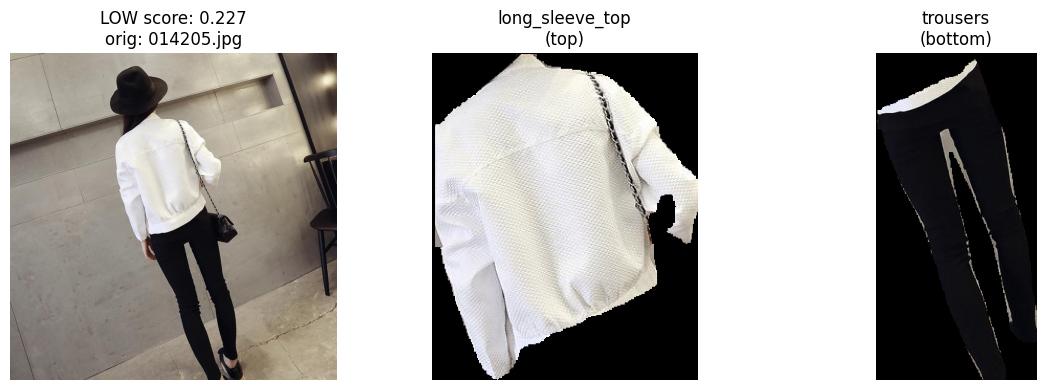

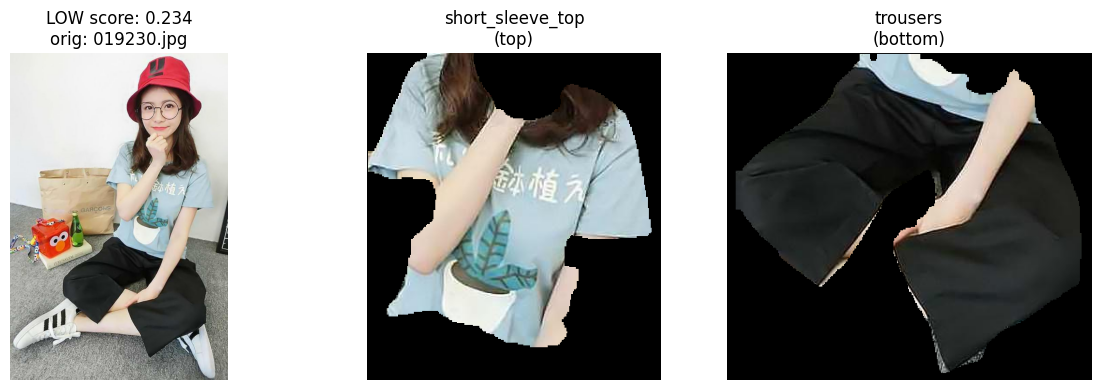

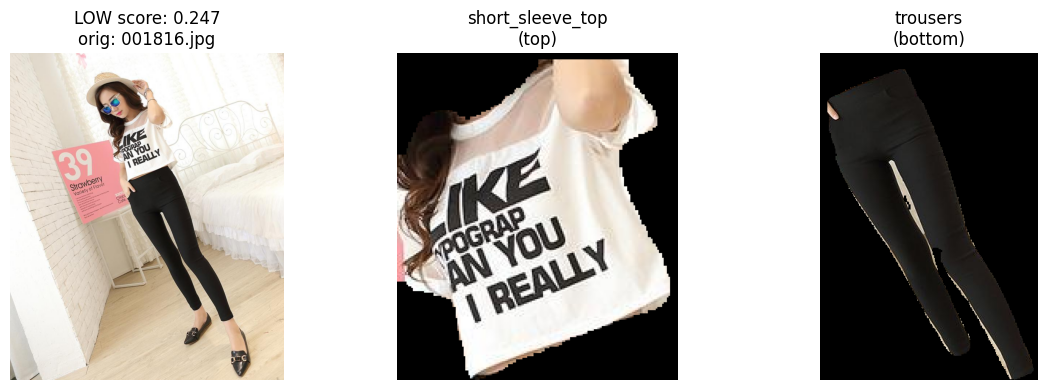

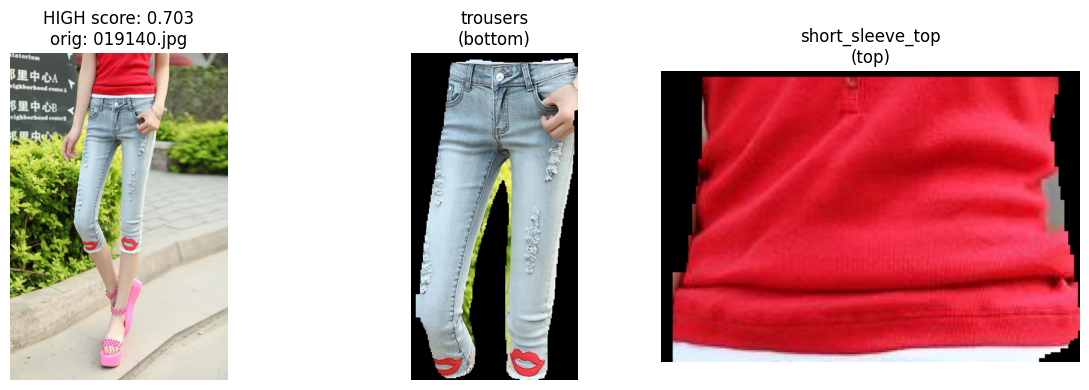

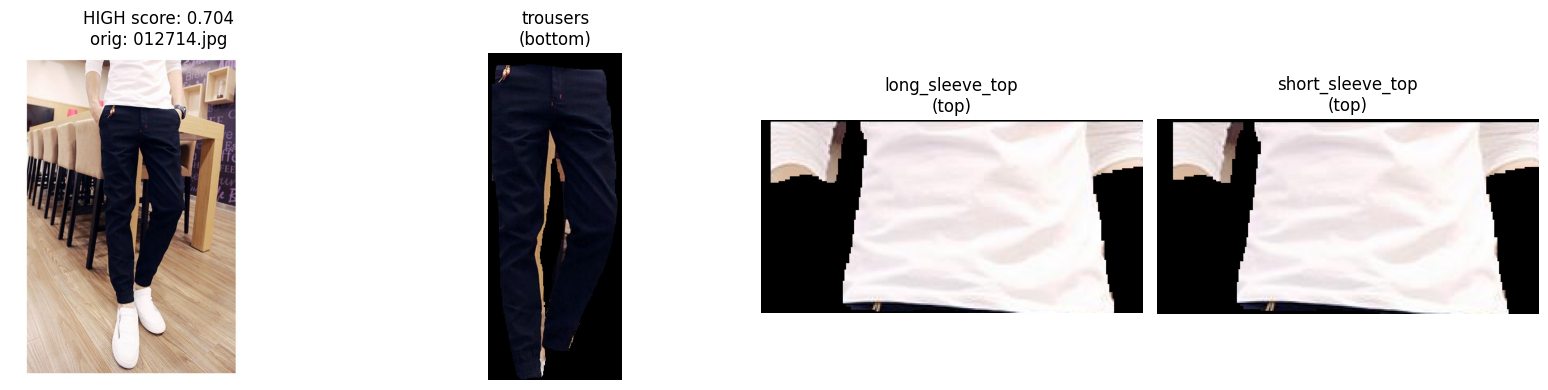

In [42]:
for res in lowest_examples:
    score = res["outfit_score"]
    title = f"LOW score: {score:.3f}"
    show_outfit_example(res, title=title, max_crops=5)

for res in highest_examples:
    score = res["outfit_score"]
    title = f"HIGH score: {score:.3f}"
    show_outfit_example(res, title=title, max_crops=5)
